In [1]:
import pandas as pd

# Process Hourly Data for 2019
2019 and before has different format

In [38]:
data = pd.read_csv("2019.csv", sep="|")

In [39]:
data.head(15)

,ValidDate,ValidTime,AQSID,SiteName,GMTOffset,MeasurementType,MeasurementUnit,RawMeasurement,DataSource
0,01/01/19,00:00,250250002,BOSTON-KENMORE,-5,NO,PPB,3.0,Massachusetts Dept. of Environmental Protection
1,01/01/19,00:00,250250002,BOSTON-KENMORE,-5,NO2,PPB,11.0,Massachusetts Dept. of Environmental Protection
2,01/01/19,00:00,250250002,BOSTON-KENMORE,-5,NOX,PPB,15.0,Massachusetts Dept. of Environmental Protection
3,01/01/19,00:00,250250002,BOSTON-KENMORE,-5,SO2,PPB,0.0,Massachusetts Dept. of Environmental Protection
4,01/01/19,00:00,250250042,Boston - Roxbury,-5,BARPR,MILLIBAR,1021.1,Massachusetts Dept. of Environmental Protection
5,01/01/19,00:00,250250042,Boston - Roxbury,-5,CO,PPM,0.2,Massachusetts Dept. of Environmental Protection
6,01/01/19,00:00,250250042,Boston - Roxbury,-5,NO,PPB,1.0,Massachusetts Dept. of Environmental Protection
7,01/01/19,00:00,250250042,Boston - Roxbury,-5,NO2,PPB,9.0,Massachusetts Dept. of Environmental Protection
8,01/01/19,00:00,250250042,Boston - Roxbury,-5,NOX,PPB,10.0,Massachusetts Dept. of Environmental Protection
9,01/01/19,00:00,250250042,Boston - Roxbury,-5,NOY,PPB,11.0,Massachusetts Dept. of Environmental Protection


In [4]:
data = data.drop(['GMTOffset', 'ValidTime', 'DataSource'], axis=1)

data.head()

,ValidDate,AQSID,SiteName,MeasurementType,MeasurementUnit,RawMeasurement
0,01/01/19,250250002,BOSTON-KENMORE,NO,PPB,3.0
1,01/01/19,250250002,BOSTON-KENMORE,NO2,PPB,11.0
2,01/01/19,250250002,BOSTON-KENMORE,NOX,PPB,15.0
3,01/01/19,250250002,BOSTON-KENMORE,SO2,PPB,0.0
4,01/01/19,250250042,Boston - Roxbury,BARPR,MILLIBAR,1021.1


In [5]:
data = data[(data['MeasurementType'] == 'NO2') | (data['MeasurementType'] == 'PM2.5') | (data['MeasurementType'] == 'OZONE') ]

data.head()

,ValidDate,AQSID,SiteName,MeasurementType,MeasurementUnit,RawMeasurement
1,01/01/19,250250002,BOSTON-KENMORE,NO2,PPB,11.0
7,01/01/19,250250042,Boston - Roxbury,NO2,PPB,9.0
10,01/01/19,250250042,Boston - Roxbury,OZONE,PPB,23.0
11,01/01/19,250250042,Boston - Roxbury,PM2.5,UG/M3,7.0
23,01/01/19,250250044,Boston-Von Hillern,NO2,PPB,8.0


In [6]:
data[data["MeasurementType"] == "PM2.5"].value_counts()

ValidDate  AQSID      SiteName            MeasurementType  MeasurementUnit  RawMeasurement
08/26/19   250250044  Boston-Von Hillern  PM2.5            UG/M3            6.0               11
11/28/19   250250042  Boston - Roxbury    PM2.5            UG/M3            6.0               10
10/12/19   250250044  Boston-Von Hillern  PM2.5            UG/M3            4.0               10
05/05/19   250250044  Boston-Von Hillern  PM2.5            UG/M3            2.0               10
10/29/19   250250042  Boston - Roxbury    PM2.5            UG/M3            6.0               10
                                                                                              ..
06/23/19   250250044  Boston-Von Hillern  PM2.5            UG/M3            8.0                1
                                                                            10.0               1
06/24/19   250250042  Boston - Roxbury    PM2.5            UG/M3            4.0                1
                                    

In [7]:
import numpy as np
import aqi 

groups = data.groupby(['ValidDate', 'SiteName', 'AQSID']).indices
new_dict = {
    "ValidDate": [],
    "AQSID": [],
    "SiteName": [],
    "OZONE_AQI": [],
    "PM25_AQI": [],
    "NO2_AQI": [],
}

for (date, site, id), indices in groups.items():
    new_dict["ValidDate"].append(date)
    new_dict["SiteName"].append(site)
    new_dict["AQSID"].append(id)

    ozone_aqi = np.nan
    pm25_aqi = np.nan
    no2_aqi = np.nan

    for i in indices:
        row = data.iloc[i]

        try:
            if row['MeasurementType'] == "NO2":
                if row['MeasurementUnit'] == "PPB":
                    no2_aqi = aqi.to_iaqi(aqi.POLLUTANT_NO2_1H, str(row['RawMeasurement']), algo=aqi.ALGO_EPA)
                else:
                    ppb = row['RawMeasurement'] * 0.51 # Convert from ug/m3 to ppb
                    no2_aqi = aqi.to_iaqi(aqi.POLLUTANT_NO2_1H, str(ppb), algo=aqi.ALGO_EPA)

            elif row['MeasurementType'] == "OZONE":
                if row['MeasurementUnit'] == "PPB":
                    ppm = row['RawMeasurement'] * 0.001 # Convert from ppb to ppm
                    ozone_aqi = aqi.to_iaqi(aqi.POLLUTANT_O3_8H, str(ppm), algo=aqi.ALGO_EPA)
                else:
                    ppm = row['RawMeasurement'] * 0.001 * 0.49 # Convert from ug/m3 to ppm
                    ozone_aqi = aqi.to_iaqi(aqi.POLLUTANT_O3_8H, str(ppm), algo=aqi.ALGO_EPA)

            elif row['MeasurementType'] == "PM2.5":
                if row['MeasurementUnit'] == "UG/M3":
                    no2_aqi = aqi.to_iaqi(aqi.POLLUTANT_PM25, str(row['RawMeasurement']), algo=aqi.ALGO_EPA)
        except:
            print(i)
    
    new_dict["OZONE_AQI"].append(ozone_aqi)
    new_dict["PM25_AQI"].append(pm25_aqi)
    new_dict["NO2_AQI"].append(no2_aqi)


new_data = pd.DataFrame(new_dict)
new_data.head(10)

105
851
2697
4025
4893
4899
4911
4917
6448
9067
9073
9919
11052
11088
11094
11100
11106
11112
11190
11196
11579
11585
11991
12381
12474
12480
12601
12819
12848
12878
12908
13134
13076
13082
13088
13399
13777
13783
13801
13835
13807
13813
13819
13831
13849
13855
13879
13933
13944
13950
14097
14339
14350
14456
14462
14672
14684
14690
14726
14738
14744
15587
15797
15809
15892
16010
16016
16269
16275
16505
16511
16553
16773
16779
17487
17781
17798
18004
18010
18260
18268
18274
18428
18681
18693
18765
18771
18846
19112
19118
19479
19485
19603
19626
19638
20516
20522
20528
20534
20540
20546
20552
20558
20564
20524
20530
20548
20838
20880
20910
20916
20918
20924
21008
21692
21698
21710
21818
21742
21790
21864
21875
21881
21866
21871
21877
22515
22523
22657
22662
23122
23065
23158
23176
23902
24594
24600
24660
24666
25382
26056
27628
27634
28276
30920
30938
30944
30950
30962
30967
30972
31615
31627
31633
31657
31663
31669
32152
32158
32188
34968
35417
35423
35847
36113
36133
37363
37353
37365


,ValidDate,AQSID,SiteName,OZONE_AQI,PM25_AQI,NO2_AQI
0,01/01/19,250250002,BOSTON-KENMORE,NaN,NaN,3
1,01/01/19,250250042,Boston - Roxbury,18,NaN,29
2,01/01/19,250250044,Boston-Von Hillern,NaN,NaN,25
3,01/02/19,250250002,BOSTON-KENMORE,NaN,NaN,30
4,01/02/19,250250042,Boston - Roxbury,10,NaN,38
5,01/02/19,250250044,Boston-Von Hillern,NaN,NaN,38
6,01/03/19,250250002,BOSTON-KENMORE,NaN,NaN,15
7,01/03/19,250250042,Boston - Roxbury,5,NaN,25
8,01/03/19,250250044,Boston-Von Hillern,NaN,NaN,38
9,01/04/19,250250002,BOSTON-KENMORE,NaN,NaN,17


In [8]:
new_data.to_csv('processed_2019.csv')

# Analyze 2019 AQI

In [45]:
df = pd.read_csv("processed_2019.csv")
df.head()

,Unnamed: 0,ValidDate,AQSID,SiteName,OZONE_AQI,PM25_AQI,NO2_AQI
0,0,01/01/19,250250002,BOSTON-KENMORE,NaN,NaN,3
1,1,01/01/19,250250042,Boston - Roxbury,18.0,NaN,29
2,2,01/01/19,250250044,Boston-Von Hillern,NaN,NaN,25
3,3,01/02/19,250250002,BOSTON-KENMORE,NaN,NaN,30
4,4,01/02/19,250250042,Boston - Roxbury,10.0,NaN,38


In [46]:
len(df['PM25_AQI'].value_counts())
# drop col with all NaN values
df = df.dropna(axis=1, how='all')
df.head()

,Unnamed: 0,ValidDate,AQSID,SiteName,OZONE_AQI,NO2_AQI
0,0,01/01/19,250250002,BOSTON-KENMORE,NaN,3
1,1,01/01/19,250250042,Boston - Roxbury,18.0,29
2,2,01/01/19,250250044,Boston-Von Hillern,NaN,25
3,3,01/02/19,250250002,BOSTON-KENMORE,NaN,30
4,4,01/02/19,250250042,Boston - Roxbury,10.0,38


In [47]:
df = df.drop(['Unnamed: 0', 'AQSID'], axis=1)
df

,ValidDate,SiteName,OZONE_AQI,NO2_AQI
0,01/01/19,BOSTON-KENMORE,NaN,3
1,01/01/19,Boston - Roxbury,18.0,29
2,01/01/19,Boston-Von Hillern,NaN,25
3,01/02/19,BOSTON-KENMORE,NaN,30
4,01/02/19,Boston - Roxbury,10.0,38
...,...,...,...,...
1074,12/30/19,Boston - Roxbury,28.0,12
1075,12/30/19,Boston-Von Hillern,NaN,12
1076,12/31/19,BOSTON-KENMORE,NaN,14
1077,12/31/19,Boston - Roxbury,14.0,12


fill null values with mean values

In [48]:
df['OZONE_AQI'].fillna(df['OZONE_AQI'].mean(), inplace=True)
df['NO2_AQI'].fillna(df['NO2_AQI'].mean(), inplace=True)

df.head()

,ValidDate,SiteName,OZONE_AQI,NO2_AQI
0,01/01/19,BOSTON-KENMORE,22.9,3
1,01/01/19,Boston - Roxbury,18.0,29
2,01/01/19,Boston-Von Hillern,22.9,25
3,01/02/19,BOSTON-KENMORE,22.9,30
4,01/02/19,Boston - Roxbury,10.0,38


In [49]:
# Sort the DataFrame by the 'ValidDate' column in ascending order
df['ValidDate'] = pd.to_datetime(df['ValidDate'])
df.sort_values(by='ValidDate', ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

df

/var/folders/37/5r4fjllx115gd2m3kmqy_02m0000gn/T/ipykernel_35124/488175098.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ValidDate'] = pd.to_datetime(df['ValidDate'])


,ValidDate,SiteName,OZONE_AQI,NO2_AQI
0,2019-01-01,BOSTON-KENMORE,22.9,3
1,2019-01-01,Boston - Roxbury,18.0,29
2,2019-01-01,Boston-Von Hillern,22.9,25
3,2019-01-02,BOSTON-KENMORE,22.9,30
4,2019-01-02,Boston - Roxbury,10.0,38
...,...,...,...,...
1074,2019-12-30,BOSTON-KENMORE,22.9,15
1075,2019-12-30,Boston-Von Hillern,22.9,12
1076,2019-12-31,Boston - Roxbury,14.0,12
1077,2019-12-31,BOSTON-KENMORE,22.9,14


In [50]:
df['ValidDate'] = pd.to_datetime(df['ValidDate'])

# Filter for numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Group by 'SiteName' and 'ValidDate' and calculate mean
agg_df = numeric_df.groupby([df['SiteName'], df['ValidDate']]).mean().reset_index()
agg_df


,SiteName,ValidDate,OZONE_AQI,NO2_AQI
0,BOSTON-KENMORE,2019-01-01,22.9,3.0
1,BOSTON-KENMORE,2019-01-02,22.9,30.0
2,BOSTON-KENMORE,2019-01-03,22.9,15.0
3,BOSTON-KENMORE,2019-01-04,22.9,17.0
4,BOSTON-KENMORE,2019-01-05,22.9,12.0
...,...,...,...,...
1074,Boston-Von Hillern,2019-12-27,22.9,38.0
1075,Boston-Von Hillern,2019-12-28,22.9,21.0
1076,Boston-Von Hillern,2019-12-29,22.9,29.0
1077,Boston-Von Hillern,2019-12-30,22.9,12.0


In [52]:
def create_avgAQI(df, interested_col, numberic_col):
    df = df[interested_col]
    df = df.groupby(['ValidDate', 'SiteName'])[numberic_col].mean()

    # create a new col call avg_AQI that takes the average of three AQI columns
    df['avg_AQI'] = df[numberic_col].mean(axis=1)
    return df

numberic_col = ['OZONE_AQI', 'NO2_AQI']
interested_col = ['SiteName', 'ValidDate'] + numberic_col
df_2019 = create_avgAQI(agg_df, interested_col, numberic_col).reset_index()
df_2019

,ValidDate,SiteName,OZONE_AQI,NO2_AQI,avg_AQI
0,2019-01-01,BOSTON-KENMORE,22.9,3.0,12.95
1,2019-01-01,Boston - Roxbury,18.0,29.0,23.50
2,2019-01-01,Boston-Von Hillern,22.9,25.0,23.95
3,2019-01-02,BOSTON-KENMORE,22.9,30.0,26.45
4,2019-01-02,Boston - Roxbury,10.0,38.0,24.00
...,...,...,...,...,...
1074,2019-12-30,Boston - Roxbury,28.0,12.0,20.00
1075,2019-12-30,Boston-Von Hillern,22.9,12.0,17.45
1076,2019-12-31,BOSTON-KENMORE,22.9,14.0,18.45
1077,2019-12-31,Boston - Roxbury,14.0,12.0,13.00


In [53]:
def ret_validDate_col(df):
    df = df.reset_index()
    df['ValidDate'] = pd.to_datetime(df['ValidDate'])
    df['ValidDate'] = df['ValidDate'].apply(lambda x: x.timetuple().tm_yday)
    return df

df_2019 = ret_validDate_col(df_2019)


In [55]:
df_2019 = df_2019.drop(['index'], axis=1)
df_2019

,ValidDate,SiteName,OZONE_AQI,NO2_AQI,avg_AQI
0,1,BOSTON-KENMORE,22.9,3.0,12.95
1,1,Boston - Roxbury,18.0,29.0,23.50
2,1,Boston-Von Hillern,22.9,25.0,23.95
3,2,BOSTON-KENMORE,22.9,30.0,26.45
4,2,Boston - Roxbury,10.0,38.0,24.00
...,...,...,...,...,...
1074,364,Boston - Roxbury,28.0,12.0,20.00
1075,364,Boston-Von Hillern,22.9,12.0,17.45
1076,365,BOSTON-KENMORE,22.9,14.0,18.45
1077,365,Boston - Roxbury,14.0,12.0,13.00


In [ ]:
df_2019.to_csv('2019_AQI_final.csv')

# Plot

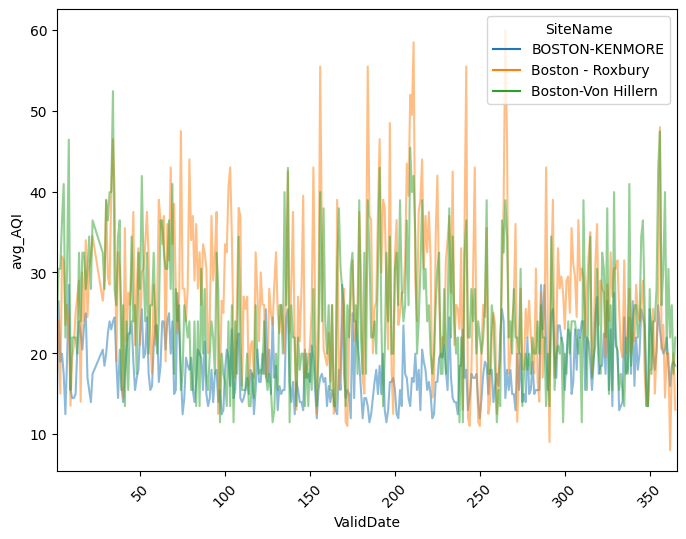

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.dates import date2num

def plot_daily_per_year(df):
    plt.figure(figsize=(8, 6))
    plt.xticks(rotation=45)

    # Create the lineplot
    lineplot = sns.lineplot(x='ValidDate', y='avg_AQI', hue='SiteName', data=df)

    # Set x-axis limits
    plt.xlim(1, 366)

    # Adjust line opacity
    for line in lineplot.lines:
        line.set_alpha(0.5)

    plt.show()

plot_daily_per_year(df_2019)

In [ ]:
# Function to assign quarter based on day of the year
def assign_quarter(day):
    if day <= 90:
        return 'Quarter 1'
    elif day <= 181:
        return 'Quarter 2'
    elif day <= 273:
        return 'Quarter 3'
    else:
        return 'Quarter 4'

# Function to process each DataFrame
def process_df(df, year, exclude_q4=False):
    df['Quarter'] = df['ValidDate'].apply(assign_quarter)
    if exclude_q4 and year == 2023:
        df = df[df['Quarter'] != 'Quarter 4']
    quarterly_avg = df.groupby('Quarter')['avg_AQI'].mean().reset_index()
    quarterly_avg['Year'] = year
    return quarterly_avg

# Process each DataFrame
df_2019_q = process_df(df_2019, 2019)

# Combine the DataFrames
combined_df = pd.concat([df_2020_q, df_2021_q, df_2022_q, df_2023_q])

plt.figure(figsize=(10, 6))

# Plotting
sns.lineplot(data=combined_df, x='Quarter', y='avg_AQI', hue='Year', marker='o')

plt.xlabel('Quarter')
plt.ylabel('Average AQI')
plt.title('Quarterly Average AQI (2020-2023)')
plt.tight_layout()
plt.savefig("../results/Quarterly Average AQI (2020-2023)")
plt.show()
